torch.Size([512, 1, 1])
torch.Size([512, 7, 7])


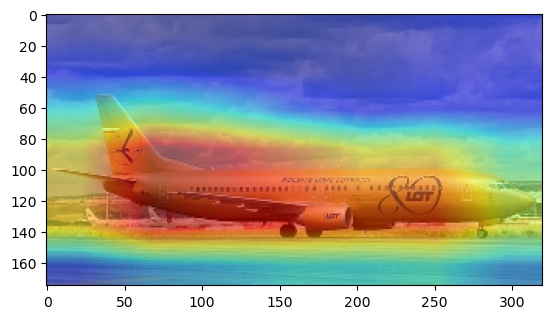

In [19]:
from torch import nn
from torchvision import models
from torchvision.models import ResNet18_Weights

model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).eval()
features = nn.Sequential(*list(model.children())[:-2])

from PIL import Image
from torchvision import transforms

transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
)

image = Image.open("./data/images/airplane.jpg")
target = transforms(image).unsqueeze(0)

output = model(target)
class_idx = int(output.argmax())

weights = model.fc.weight[class_idx].reshape(-1, 1, 1)
features_output = features(target).squeeze()

print(weights.shape)
print(features_output.shape)

import torch
from torch.nn import functional as F

cam = features_output * weights
cam = torch.sum(cam, dim=0)
cam = F.interpolate(
    input=cam.unsqueeze(0).unsqueeze(0),
    size=(image.size[1], image.size[0]),
    mode="bilinear",
).squeeze().detach().numpy()

import matplotlib.pyplot as plt

plt.imshow(image)
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.show()

In [ ]:
import torch

class GradCAM:
    def __init__(self, model, main, sub):
        self.model = model.eval()
        self.register_hook(main, sub)
    
    def register_hook(self, main, sub):
        for name, module in self.model.named_children():
            if name == main:
                for sub_name, sub_module in module[-1].named_children():
                    if sub_name == sub:
                        sub_module.register_forward_hook(self.forward_hook)
                        sub_module.register_full_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.feature_map = output
    
    def backward_hook(self, module, grad_input, grad_output):
        self.gradient = grad_output[0]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

100%|██████████| 16/16 [00:00<00:00, 58.14it/s]


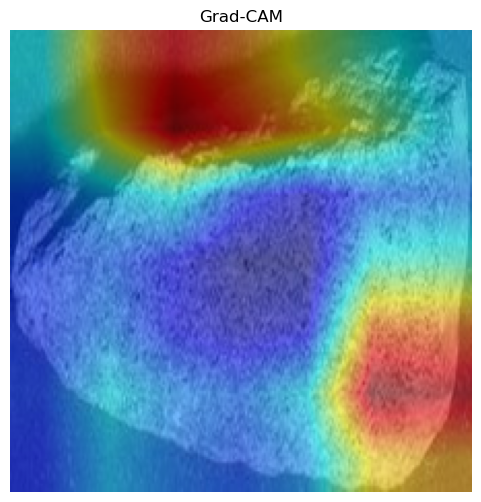

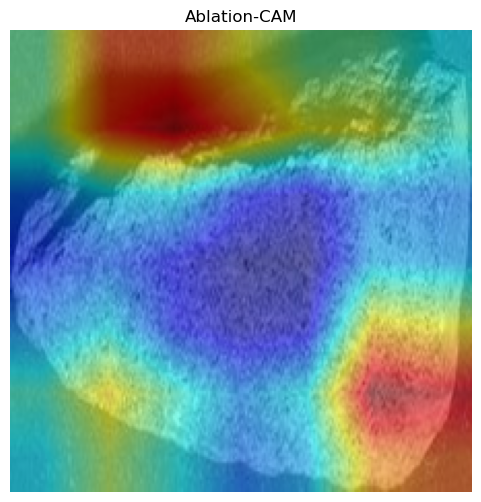

In [27]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import models
from torchvision.models import ResNet18_Weights
from PIL import Image
from torchvision import transforms

from pytorch_grad_cam import GradCAM, AblationCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).eval().to(device)
print(model)

transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
)

image = Image.open("./data/rock_test.jpg")
input_tensor  = transforms(image).unsqueeze(0).to(device)

# 자동으로 Top-1 예측 class 사용
output = model(input_tensor)
top_class = output.argmax(dim=1).item()

# CAM 시각화를 위한 RGB 원본 이미지 (0~1, float32, numpy)
rgb_image = np.array(image.resize((224, 224))).astype(np.float32) / 255.0

# 타겟 레이어 및 클래스 지정
target_layer = model.layer4[-1]
targets = [ClassifierOutputTarget(top_class)] 

# Grad-CAM
cam_grad = GradCAM(model=model, target_layers=[target_layer])
grayscale_cam_grad = cam_grad(input_tensor=input_tensor, targets=targets)[0]
visual_grad = show_cam_on_image(rgb_image, grayscale_cam_grad, use_rgb=True)

# Ablation-CAM
cam_ablation = AblationCAM(model=model, target_layers=[target_layer])
grayscale_cam_ablation = cam_ablation(input_tensor=input_tensor, targets=targets)[0]
visual_ablation = show_cam_on_image(rgb_image, grayscale_cam_ablation, use_rgb=True)

# 시각화 함수
def show_cam(title, image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Grad-CAM 시각화
show_cam("Grad-CAM", visual_grad)

# Ablation-CAM 시각화
show_cam("Ablation-CAM", visual_ablation)